# Imports

In [20]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import time
from PIL import Image

# SLM image display

Looking at the SLM-200 manual we can encode rgb to 10-bit in the following way

<img src="rgb_to_10bit.png" alt="Drawing" style="width: 500px;"/>

In [3]:
#each channel in a pixel has an 8-bit long representation
value=255
print(value)
print(bin(value)) 

255
0b11111111


In [4]:
#integer division by 32 gives the first 3bits, range 0-7. 
three_bit = value//32
print(three_bit) 
print(bin(three_bit))

7
0b111


In [5]:
#integer division by 16 gives the first 4bits, range 0-15. 
four_bit = value//16
print(four_bit) 
print(bin(four_bit))

15
0b1111


To sum up, we want to convert from 10bit to 8bit tuples. Extract the first 3 bits for red then the next 3 bits for green and finally the last 4 bits for blue (see figure). That's how we convert the 10-bit grayscale to an rgb image. 

# Generate data

In [6]:
#A useful function for testing rgb
def make_rgb(random= False):
    """
    Generates an rgb tuple
    """
    if random:
        values = np.floor(np.random.random(3)*255)
    else:
        values = [255,255,255]
    rgb = np.array(values).reshape(3,)
    rgb = np.uint8(rgb)
    return rgb

make_rgb(1)

array([127,  36,  54], dtype=uint8)

In [7]:
rgb = make_rgb()
print(rgb)

[255 255 255]


In [8]:
#A useful function for testing 10bit
def make_10bit(random=False):
    """
    Generates a 10-bit value
    """
    if random:
        value = np.floor(np.random.random()*1024)
    else:
        value = 1023
    
    value = np.uint16(value)
    return value

In [9]:
ten_bit = make_10bit()
print(ten_bit)

1023


In [10]:
rgb = make_rgb(random=True)
grey = make_10bit(random=True)
print("RGB: {} Greyscale: {}".format(rgb, grey))

RGB: [215  39 205] Greyscale: 101


# Conversion

In [11]:
def convert_pixel_10bit_rgb(pixel, verbose=False):
    pixel = np.uint16(pixel)
    if verbose:
        print ("input:", pixel)
        print (bin(pixel))
    
    binary = np.unpackbits(np.array([pixel]).view(np.uint8)[::-1])
    if verbose:
        print("binary: ", binary[6:])
    
    result = binary[6:]
    
    #Now we use the first 3 bits for red, the next 3 bits for green and the last 4 bits for blue
    red = np.concatenate([result[:3], np.zeros(5, dtype=np.uint8)])
    green = np.concatenate([result[3:6], np.zeros(5, dtype=np.uint8)])
    blue = np.concatenate([result[6:10], np.zeros(4, dtype=np.uint8)])
    if verbose:
        print("rgb paded binary: ", red, green, blue)
    
    red = np.packbits(red)
    green = np.packbits(green)
    blue = np.packbits(blue)
    
    result = (red.item() ,green.item() ,blue.item())
    
    if verbose:
        print("result", result)
        
    return result

In [12]:
grey = make_10bit(random=True)
convert_pixel_10bit_rgb(grey, verbose= True)

input: 664
0b1010011000
binary:  [1 0 1 0 0 1 1 0 0 0]
rgb paded binary:  [1 0 1 0 0 0 0 0] [0 0 1 0 0 0 0 0] [1 0 0 0 0 0 0 0]
result (160, 32, 128)


(160, 32, 128)

It seems that we can take on individual pixels. Now let's use convert_pixel_10bit to convert each pixel of an image

# Image conversion

In [41]:
image = np.random.randint(0, 1023, (256,192))

def convert_10bit_rgb(image, verbose= False):
    new = np.empty((image.shape[0], image.shape[1],3), dtype=np.uint8)
    for i, row in enumerate(image):
        for j, pixel in enumerate(row):
            new[i][j] = np.array(convert_pixel_10bit_rgb(pixel))
            
            if verbose and i%(image.shape[0]//3)==0 and j%(image.shape[1]//3)==0:
                print("10-bit", pixel)
                print("rgb", new[i][j])
                
    return new

new = convert_10bit_rgb(image, verbose= True)

10-bit 508
rgb [ 96 224 192]
10-bit 616
rgb [128 192 128]
10-bit 672
rgb [160  64   0]
10-bit 163
rgb [32 64 48]
10-bit 291
rgb [64 64 48]
10-bit 620
rgb [128 192 192]
10-bit 133
rgb [32  0 80]
10-bit 589
rgb [128 128 208]
10-bit 327
rgb [ 64 128 112]
10-bit 972
rgb [224 128 192]
10-bit 921
rgb [224  32 144]
10-bit 27
rgb [  0  32 176]


In [42]:
new.mean()

114.66786024305556

In [43]:
a = (3,2,4)
print(a)

(3, 2, 4)


In [44]:
str(a)

'(3, 2, 4)'

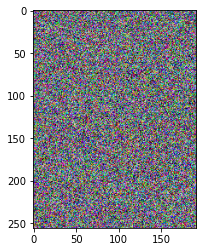

In [45]:
plt.imshow(new)
img = Image.fromarray(new, 'RGB')
img.save('out.png')

In [46]:
#Vectorize
"""
The following idea could work for vectorizing i.e. not looping. Calculate the integer divisions for each power of 2 from 2**0 up to 2**9. take mod 2 of the matrix
if the result is odd, the corresponding bit is 1, if the result is even, the corresponding bit is 0. If this is vectorized by numpy, it can potentially
be faster to calculate the 9 matrices, elevate 2 to the appropiate powers and add them up for each channel.

You will get 10 matrices. You can now calculate the red, green and blue channels independently. Finally, you can make a new matrix fusing the
3 channels, hopefully in a vectorized way. (consider using torch.stack() if numpy cannot here.)
"""
0

0

Now let's move on to displaying the image full-screen on a 2nd display (the SLM)

# Second display

In [47]:
# Write down screen resolution for each monitor
height1 = 1080
width1 = 1920

# In case you use 2 monitors
height2= 1024
width2 = 768

# Resolution of the projector used (here the resoluton of the picopro)
height_projector = 720
width_projector = 1280

In [51]:
window_name = 'projector' 

images = []
images.append(cv2.imread("RGB_to_10bit.png"))
images.append(cv2.imread("out.png"))

cv2.namedWindow(window_name, cv2.WND_PROP_FULLSCREEN)
    
# If projector is placed right to main screen (see windows properties in your operating system)
# if the pattern is displayed at the wrong monitor you need to play around with the coordinates here until the image is displayed at the right screen
cv2.moveWindow(window_name, width1, 0)
    
# Set some properties to make it full screen and borderless
cv2.setWindowProperty(window_name, cv2.WND_PROP_FULLSCREEN,cv2.WINDOW_FULLSCREEN)

# Loop through 
for i, img in enumerate(images):
    cur_img = img
    cv2.imshow(window_name, cur_img)
    # wait for 1000 ms ( syncrhonize this with your aquisition time)
    cv2.waitKey(20000) # ms

# Don't forgot to close all windows at the end of aquisition
cv2.destroyAllWindows()